# Population Segmentation Dataset
### Objective 
- An unsupervised learning model to seek clusters in the Population Segmentation Data and US Census Data that reveal some sort of demographic traits the define their similarities for different regions (Indexed by concatenating State-County) in the United States


## 1. DATA COLLECTION WITH AWS S3
- Use AWS S3 bucket is a storage location to Pop Segmentation dataset

## 2. EXPLORATORY DATA ANALYSIS & DATA CLEANING
- Find missing values (replace them with mean/media/mode, KNN, or KMEANs) 
- plot distribution 
- plot pie chart 

## 3. FEATURE ENGINEERING
- KMeans and DBSCAN uses euclidean distance
- We want to minimize the distance length between two points in Euclidean space (it's required to scale the data)
- Find different ways to scale the data (Gussian Distribution)
- Logarithmic Transformation
- Box-Cox Transformation
- Standard Scaler (z-score)

## 4. FEATURE SELECTION
- Dropping low variance variables 
- Pearson Correlation 
- Principal Component Analysis

In [1]:
import pandas as pd 
import numpy as np 
import boto3
import io
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
import scipy.stats as stats
from pprint import pprint
import pylab

# 1. DATA COLLECTION WITH AWS S3

In [2]:
# use boto3 client to get S3 bucket
s3_client = boto3.client('s3')
obj_list=s3_client.list_objects(Bucket='aws-ml-blog-sagemaker-census-segmentation')

# print objects in S3 bucket
files=[]
for contents in obj_list['Contents']:
    files.append(contents['Key'])
file_name=files[0]


data_object = s3_client.get_object(Bucket='aws-ml-blog-sagemaker-census-segmentation', Key=file_name)
data_body = data_object["Body"].read()
data_stream = io.BytesIO(data_body)

# create a pandas dataframe
df = pd.read_csv(data_stream, header=0, delimiter=",") 
df.head()

,CensusId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1001,Alabama,Autauga,55221,26745,28476,2.6,75.8,18.5,0.4,...,0.5,1.3,1.8,26.5,23986,73.6,20.9,5.5,0.0,7.6
1,1003,Alabama,Baldwin,195121,95314,99807,4.5,83.1,9.5,0.6,...,1.0,1.4,3.9,26.4,85953,81.5,12.3,5.8,0.4,7.5
2,1005,Alabama,Barbour,26932,14497,12435,4.6,46.2,46.7,0.2,...,1.8,1.5,1.6,24.1,8597,71.8,20.8,7.3,0.1,17.6
3,1007,Alabama,Bibb,22604,12073,10531,2.2,74.5,21.4,0.4,...,0.6,1.5,0.7,28.8,8294,76.8,16.1,6.7,0.4,8.3
4,1009,Alabama,Blount,57710,28512,29198,8.6,87.9,1.5,0.3,...,0.9,0.4,2.3,34.9,22189,82.0,13.5,4.2,0.4,7.7


In [3]:
# Combine 'State' and 'County' and index the column
df.index = df['State'] + '-' + df['County']
# drop the 'CensusId', 'State', 'County' columns
df = df.drop(['CensusId', 'State', 'County'], axis=1)

# EXPLORATORY DATA ANALYSIS & DATA CLEANING

In [4]:
# provides a quantitative summary for each column (count, mean, std, min, max, etc)
df.describe()

,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,Citizen,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
count,3.220000e+03,3.220000e+03,3.220000e+03,3220.000000,3220.000000,3220.000000,3220.000000,3220.000000,3220.000000,3.220000e+03,...,3220.000000,3220.000000,3220.000000,3220.000000,3.220000e+03,3220.000000,3220.000000,3220.000000,3220.000000,3220.000000
mean,9.940935e+04,4.889694e+04,5.051241e+04,11.011522,75.428789,8.665497,1.723509,1.229068,0.082733,6.993507e+04,...,3.323509,1.612733,4.631770,23.278758,4.559352e+04,74.219348,17.560870,7.931801,0.288106,8.094441
std,3.193055e+05,1.566813e+05,1.626620e+05,19.241380,22.932890,14.279122,7.253115,2.633079,0.734931,2.051189e+05,...,3.756096,1.670988,3.178772,5.600466,1.496995e+05,7.863188,6.510354,3.914974,0.455137,4.096114
min,8.500000e+01,4.200000e+01,4.300000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000e+01,...,0.000000,0.000000,0.000000,4.900000,6.200000e+01,25.000000,5.800000,0.000000,0.000000,0.000000
25%,1.121800e+04,5.637250e+03,5.572000e+03,1.900000,64.100000,0.500000,0.100000,0.200000,0.000000,8.450500e+03,...,1.400000,0.900000,2.700000,19.500000,4.550750e+03,70.500000,13.100000,5.400000,0.100000,5.500000
50%,2.603500e+04,1.293200e+04,1.305700e+04,3.900000,84.100000,1.900000,0.300000,0.500000,0.000000,1.964300e+04,...,2.400000,1.300000,3.900000,23.000000,1.050800e+04,75.700000,16.200000,6.900000,0.200000,7.600000
75%,6.643050e+04,3.299275e+04,3.348750e+04,9.825000,93.200000,9.600000,0.600000,1.200000,0.000000,4.992050e+04,...,4.000000,1.900000,5.600000,26.800000,2.863275e+04,79.700000,20.500000,9.400000,0.300000,9.900000
max,1.003839e+07,4.945351e+06,5.093037e+06,99.900000,99.800000,85.900000,92.100000,41.600000,35.300000,6.046749e+06,...,71.200000,39.100000,37.200000,44.000000,4.635465e+06,88.300000,66.200000,36.600000,9.800000,36.500000


In [5]:
print(f'Number of rows of DataFrame {df.shape[0]}')
print(f'Number of columns of DataFrame {df.shape[1]}')

Number of rows of DataFrame 3220
Number of columns of DataFrame 34


In [6]:
# get datatype for each feature (string, float, int, bool, object, etc)
# State and County are object
pprint(df.columns.to_series().groupby(df.dtypes).groups)

{dtype('int64'): Index(['TotalPop', 'Men', 'Women', 'Citizen', 'IncomePerCap',
       'IncomePerCapErr', 'Employed'],
      dtype='object'),
 dtype('float64'): Index(['Hispanic', 'White', 'Black', 'Native', 'Asian', 'Pacific', 'Income',
       'IncomeErr', 'Poverty', 'ChildPoverty', 'Professional', 'Service',
       'Office', 'Construction', 'Production', 'Drive', 'Carpool', 'Transit',
       'Walk', 'OtherTransp', 'WorkAtHome', 'MeanCommute', 'PrivateWork',
       'PublicWork', 'SelfEmployed', 'FamilyWork', 'Unemployment'],
      dtype='object')}


In [7]:
features = df.columns
numerical_feat = [features for features in df.columns if df[features].dtypes != 'O']
print(f'Number of Numerical Features: {len(numerical_feat)}')

categorical_feat = [features for features in df.columns if df[features].dtypes == 'O']
print(f'Number of Categorical Features: {len(categorical_feat)}')

Number of Numerical Features: 34
Number of Categorical Features: 0


# Find Missing Values

In [8]:
# find null values in DataFrame
if df.isnull().sum().any() == False:
    print('Data is Clean, No Null values found')
else:
    print('Found Null Values')

Found Null Values


In [9]:
# create a pandas dataframe with data_type, num_null_values, and percentage of null_values for each feature
df_details = pd.DataFrame(df.dtypes).T.rename(index={0:'datatype'})
df_details = df_details.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'num_null_values'}))
df_details = df_details.append(pd.DataFrame(df.isnull().sum()/len(df)*100).T.rename(index={0:'pct_null_values'}))
df_details

,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,Citizen,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
datatype,int64,int64,int64,float64,float64,float64,float64,float64,float64,int64,...,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64
num_null_values,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
pct_null_values,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Fill Null Values with Median since there's outliers

<AxesSubplot:>

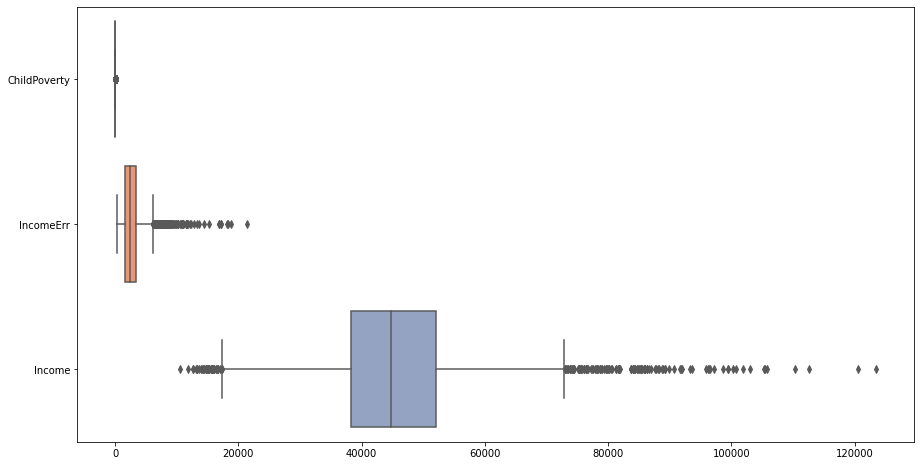

In [10]:
# Null values can be dropped, replaced by Median, Mean, or t-SNE
# Before filling Null values, analyz the data distribution for [ChildPoverty, IncomeErr, Income]
null_col = ['ChildPoverty', 'IncomeErr', 'Income']
plt.subplots(figsize=(15,8))
sns.boxplot(data=df[null_col], orient="h", palette="Set2")

In [11]:
# given the boxplot, there's alot of extreme values in IncomeErr and Income
# fill in null values with median, not mean (mean is sensitive to extreme values)
df = df.fillna(df.median())

In [12]:
# Verify if DataFrame still has null values 
if df.isnull().sum().any() == False:
    print('Data is Clean, No Null values found')
else:
    print('Found Null Values')

Data is Clean, No Null values found


In [13]:
df.columns

Index(['TotalPop', 'Men', 'Women', 'Hispanic', 'White', 'Black', 'Native',
       'Asian', 'Pacific', 'Citizen', 'Income', 'IncomeErr', 'IncomePerCap',
       'IncomePerCapErr', 'Poverty', 'ChildPoverty', 'Professional', 'Service',
       'Office', 'Construction', 'Production', 'Drive', 'Carpool', 'Transit',
       'Walk', 'OtherTransp', 'WorkAtHome', 'MeanCommute', 'Employed',
       'PrivateWork', 'PublicWork', 'SelfEmployed', 'FamilyWork',
       'Unemployment'],
      dtype='object')

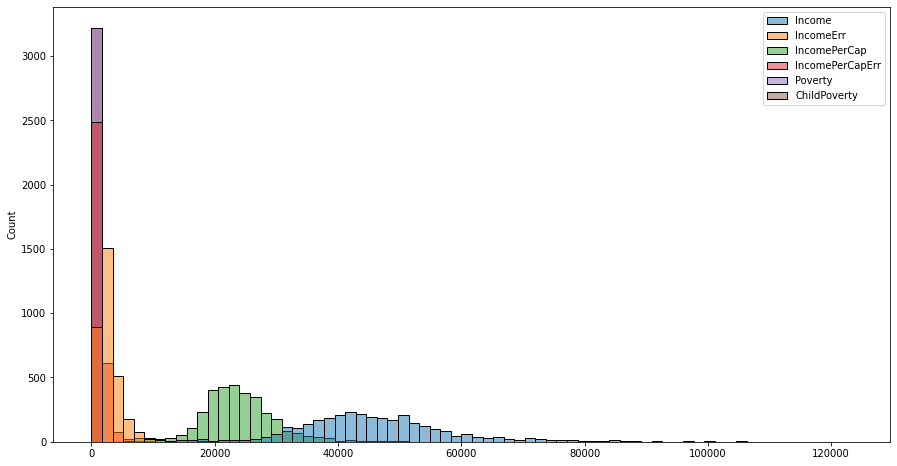

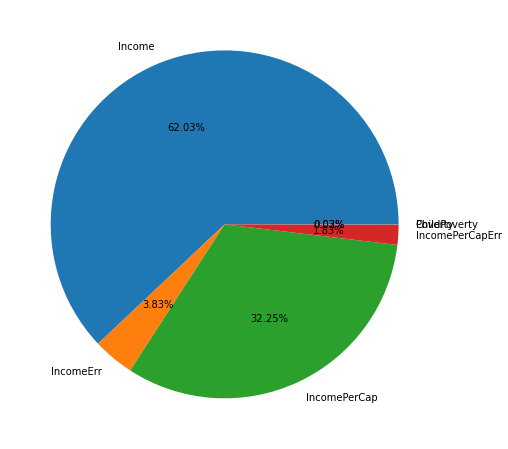

In [14]:
# income_list features historgram 
income_list = ['Income', 'IncomeErr', 'IncomePerCap', 'IncomePerCapErr', 'Poverty', 'ChildPoverty']
plt.subplots(figsize=(15,8))
sns.histplot(df[income_list].astype(float))


# pie chart of income sum
sizes = [df['Income'].sum(),
         df['IncomeErr'].sum(),
         df['IncomePerCap'].sum(),
         df['IncomePerCapErr'].sum(),
         df['Poverty'].sum(),
         df['ChildPoverty'].sum()
         
        ]
fig1, ax1 = plt.subplots(figsize=(8,8))
ax1.pie(sizes, labels=income_list, autopct='%1.2f%%')
plt.show()


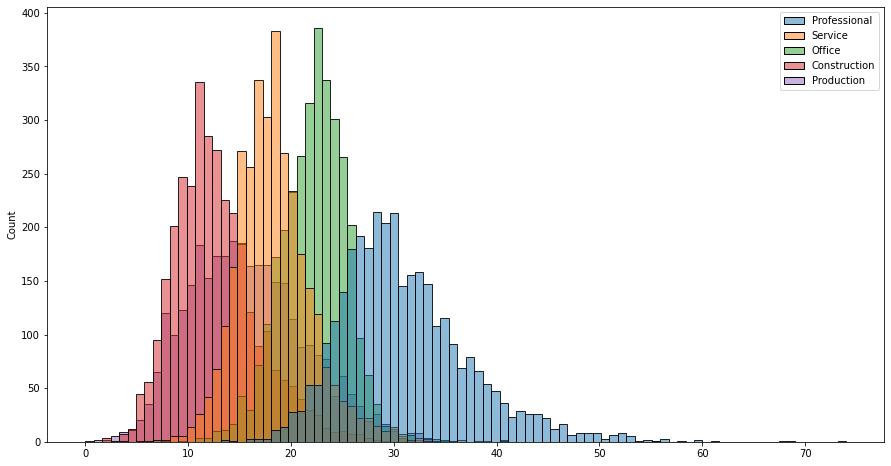

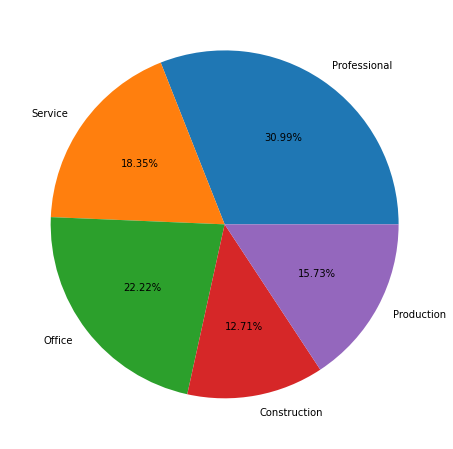

In [15]:
# occupation_list features historgram 
occupation_list = ['Professional', 'Service', 'Office', 'Construction', 'Production']
plt.subplots(figsize=(15,8))
sns.histplot(df[occupation_list].astype(float))

sizes = [df['Professional'].sum(),
         df['Service'].sum(),
         df['Office'].sum(),
         df['Construction'].sum(),
         df['Production'].sum(),         
        ]
fig1, ax1 = plt.subplots(figsize=(8,8))
ax1.pie(sizes, labels=occupation_list, autopct='%1.2f%%', shadow=False)
plt.show()

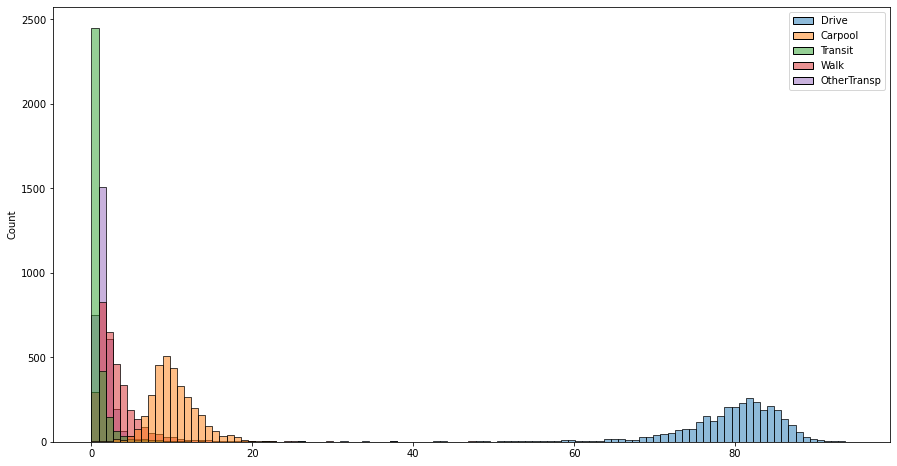

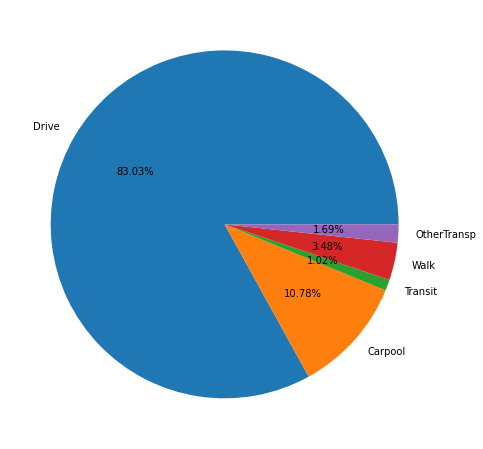

In [16]:
# transportation features historgram 
transportation_list = ['Drive', 'Carpool', 'Transit', 'Walk', 'OtherTransp']
plt.subplots(figsize=(15,8))
sns.histplot(df[transportation_list].astype(float))


# pie chart of transportation_list
sizes = [df['Drive'].sum(),
         df['Carpool'].sum(),
         df['Transit'].sum(),
         df['Walk'].sum(),
         df['OtherTransp'].sum(),         
        ]
fig1, ax1 = plt.subplots(figsize=(8,8))
ax1.pie(sizes, labels=transportation_list, autopct='%1.2f%%', shadow=False)
plt.show()

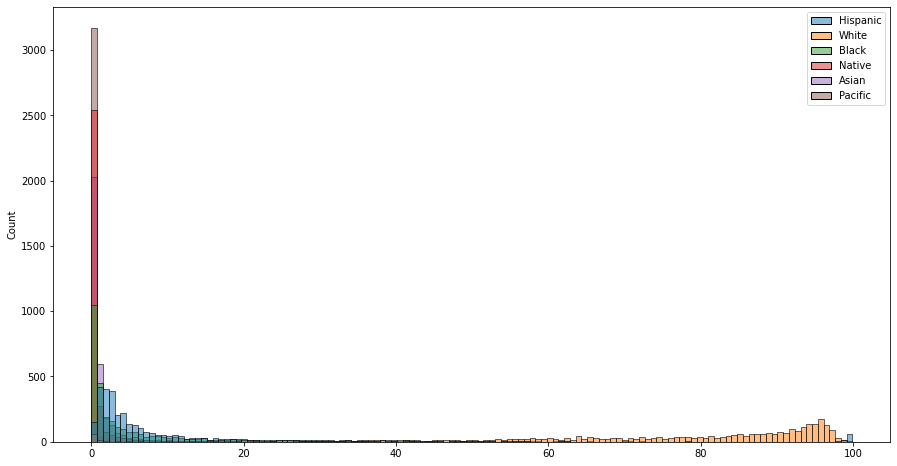

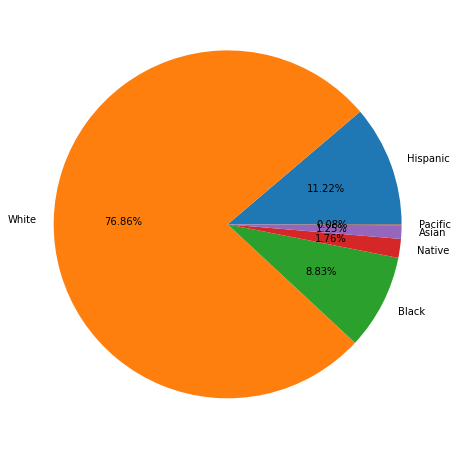

In [17]:
# race features historgram  
race_list = ['Hispanic', 'White', 'Black', 'Native', 'Asian','Pacific']
plt.subplots(figsize=(15,8))
sns.histplot(df[race_list].astype(float))

# pie chart of race_list
sizes = [df['Hispanic'].sum(),
         df['White'].sum(),
         df['Black'].sum(),
         df['Native'].sum(),
         df['Asian'].sum(),
         df['Pacific'].sum()
         
        ]
fig1, ax1 = plt.subplots(figsize=(8,8))
ax1.pie(sizes, labels=race_list, autopct='%1.2f%%', shadow=False)
plt.show()

# VISUALIZE PEARSON CORRELATION 
## Helps identify any strong correlation between variables

<AxesSubplot:>

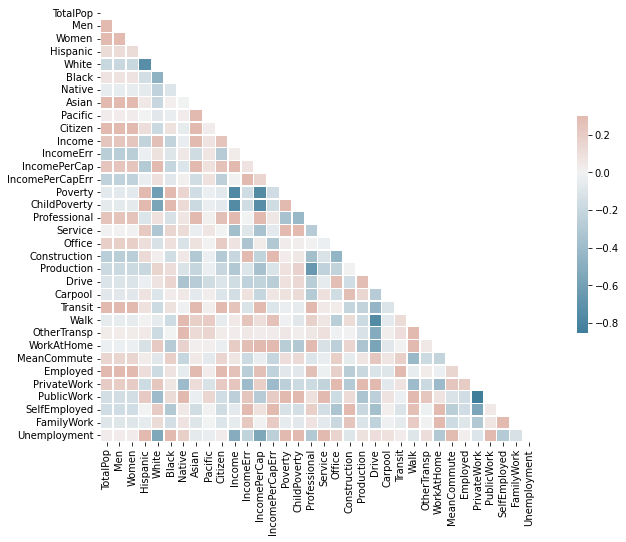

In [18]:
# compute corr array and generate a mask for the upper triangle
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.subplots(figsize=(15,8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# plt heatmap with mask and ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# looks like [Poverty, ChildPoverty] are highly correlated with [Income, Income Cap]

# FEATURE ENGINEERING 

## Define Index as State + County

In [19]:
old_columns = df.columns

# Box-Plot
## Identifies outliers

<AxesSubplot:>

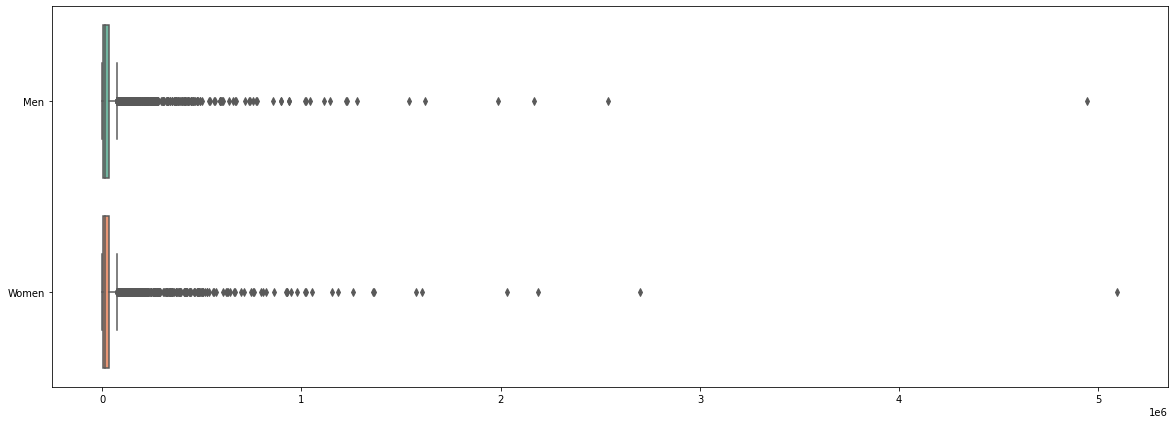

In [20]:
gender_list = ['Men', 'Women',]
plt.subplots(figsize=(20,7))
sns.boxplot(data=df[gender_list], orient="h", palette="Set2")

# Box Plot for Race Features

<AxesSubplot:>

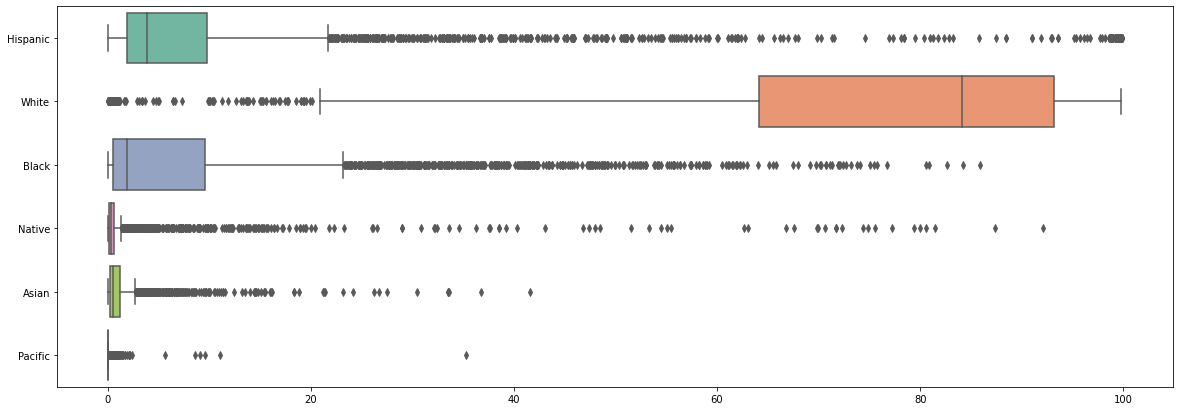

In [21]:
plt.subplots(figsize=(20,7))
sns.boxplot(data=df[race_list], orient="h", palette="Set2")

# Box Plot for Occupations Features

<AxesSubplot:>

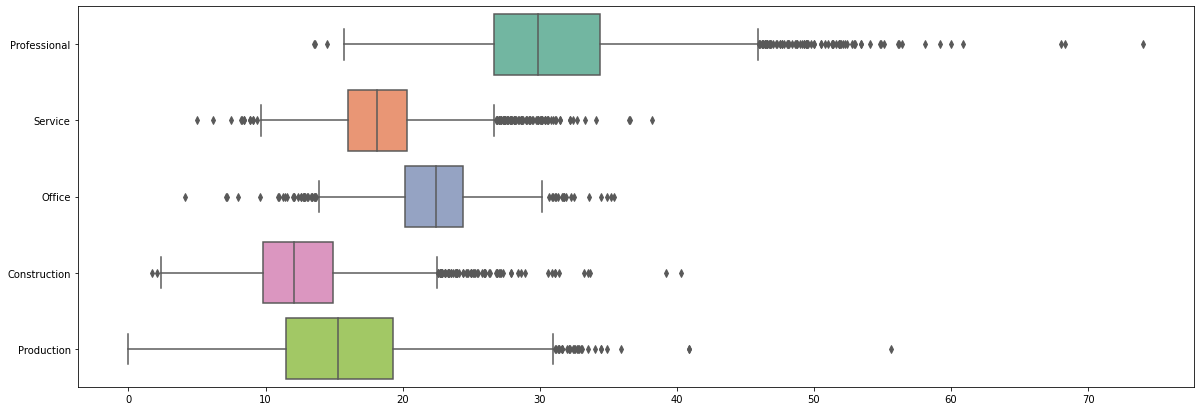

In [22]:
plt.subplots(figsize=(20,7))
sns.boxplot(data=df[occupation_list], orient="h", palette="Set2")

# Box Plot for Transportation Features

<AxesSubplot:>

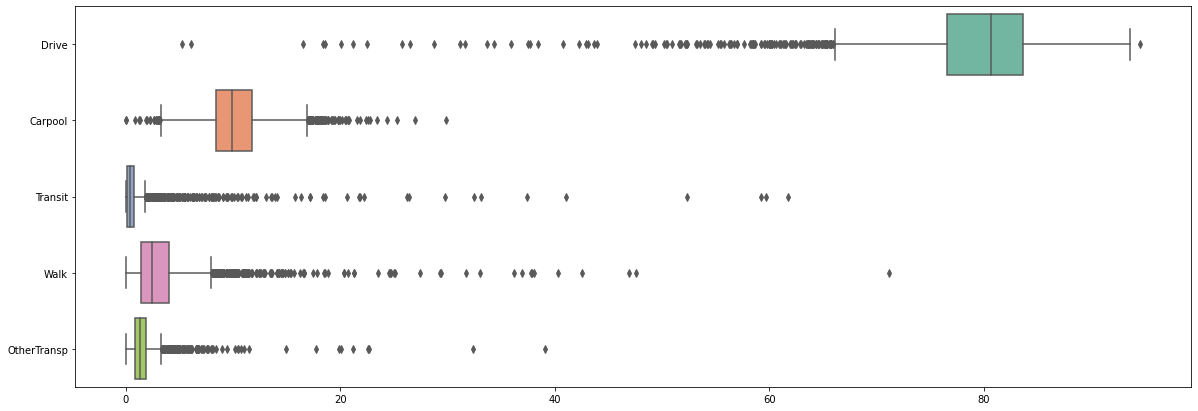

In [23]:
plt.subplots(figsize=(20,7))
sns.boxplot(data=df[transportation_list], orient="h", palette="Set2")

# Box Plot for Income Features

<AxesSubplot:>

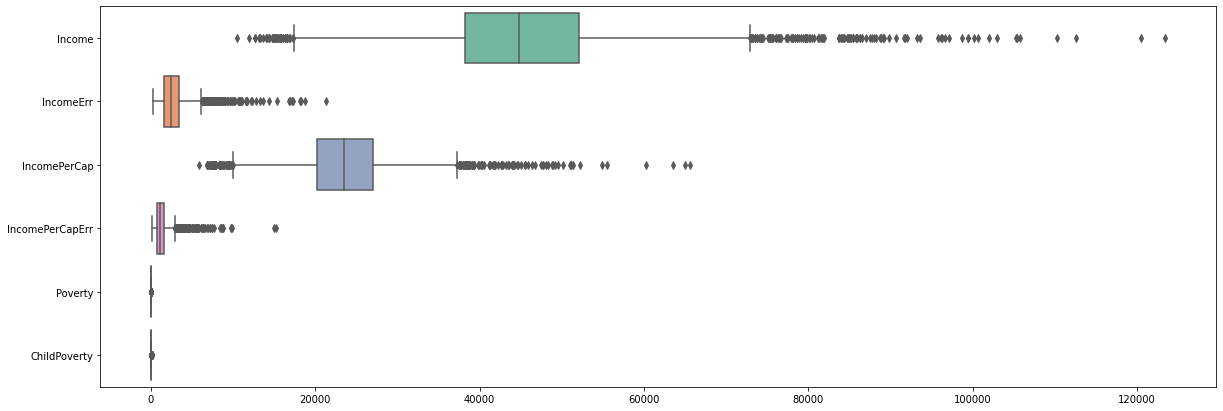

In [24]:
plt.subplots(figsize=(20,7))
sns.boxplot(data=df[income_list], orient="h", palette="Set2")

# Implement Guassian Transformation for each cluster
- Logarithmic Transformation
- Reciprocal Transformation
- Square-Root Transformation
- Exponential Transformation
- Box-Cox Transformation

In [25]:
# plot two diagram (distribution histogram and boxplot)
def plot_distribution(df, feature):
	plt.figure(figsize=(10,6))
	# first row, 1st column
	plt.subplot(1, 2, 1)
	df[feature].hist()
	# first row, 2 column
	plt.subplot(1, 2, 2)
	stats.probplot(df[feature], dist='norm', plot=pylab)
	plt.show()

In [26]:
# plot two diagram (distribution histogram and boxplot)
def plot_data_transformation(df, feature, feature_transform):
	plt.figure(figsize=(20,6))
	plt.subplot(1, 4, 1)
	stats.probplot(df[feature], dist='norm', plot=pylab)

	plt.subplot(1, 4, 2) 
	df[feature].hist()
     
	plt.subplot(1, 4, 3)
	stats.probplot(df[feature_transform], dist='norm', plot=pylab)

	plt.subplot(1, 4, 4)
	df[feature_transform].hist()
	plt.show()

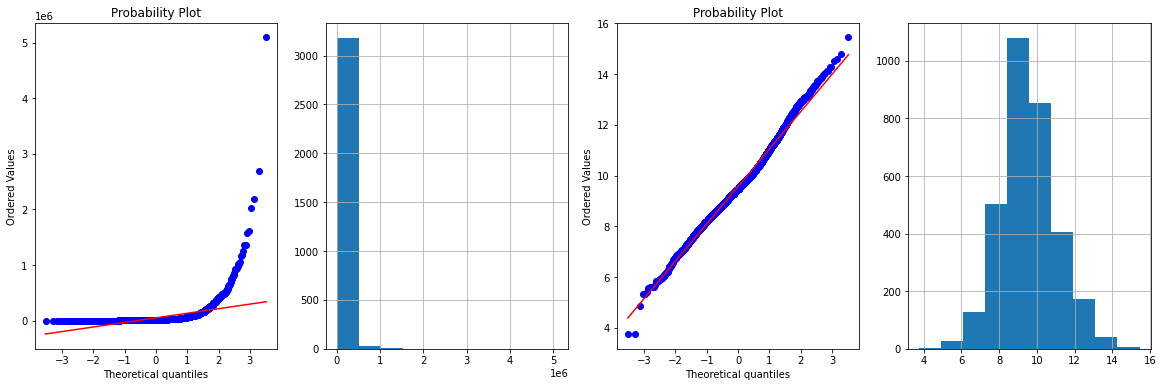

In [27]:
# Gender Transformation using Logarithmic 
def transform_feature_log(df, feature):
    df[feature+'_log'] = np.log(df[feature])

for i in gender_list:
        transform_feature_log(df, i)

plot_data_transformation(df, 'Women', 'Women_log')

In [28]:
def transform_feature_scale(df, feature):
    scaler = StandardScaler()
    df[[feature+'_scale']] = scaler.fit_transform(df[[feature]])
    
for i in race_list:
    transform_feature_scale(df, i)

/opt/anaconda3/envs/tf/lib/python3.7/site-packages/pandas/core/arraylike.py:274: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


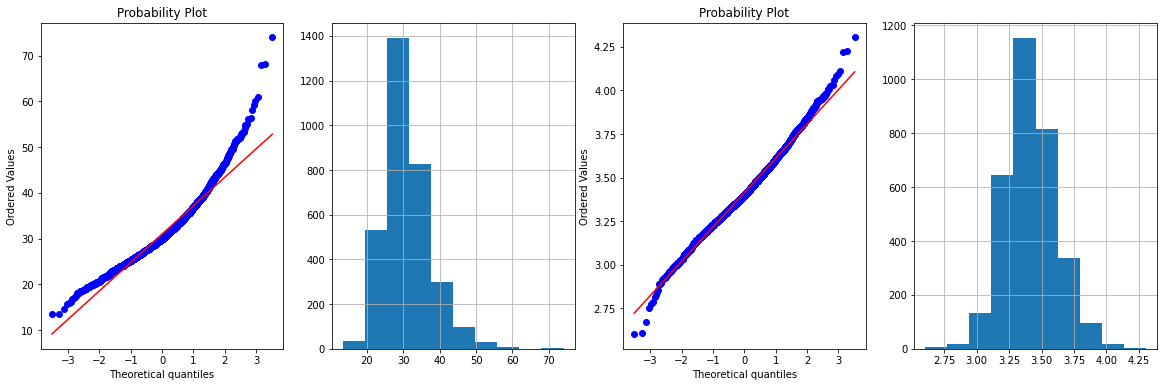

In [29]:
# Occupation Tranformation 
def transform_feature_box(df, feature):
    df[feature+'_boxcox'], _ = stats.boxcox(df[feature] + 1)
    
for i in occupation_list:
    transform_feature_log(df, i)
    
plot_data_transformation(df, 'Professional', 'Professional_log')

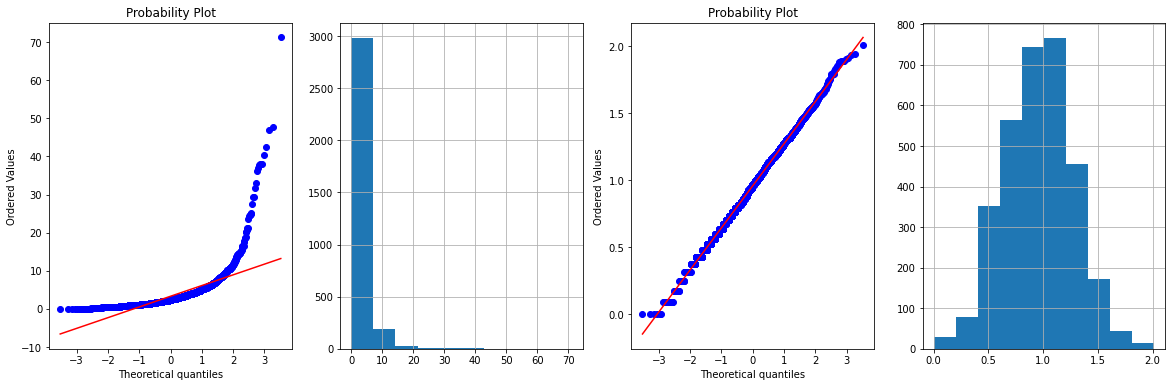

In [30]:
# Transportation Transformation using Boxcox 
for i in transportation_list:
    transform_feature_box(df, i)

plot_data_transformation(df, 'Walk', 'Walk_boxcox')

/opt/anaconda3/envs/tf/lib/python3.7/site-packages/pandas/core/arraylike.py:274: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


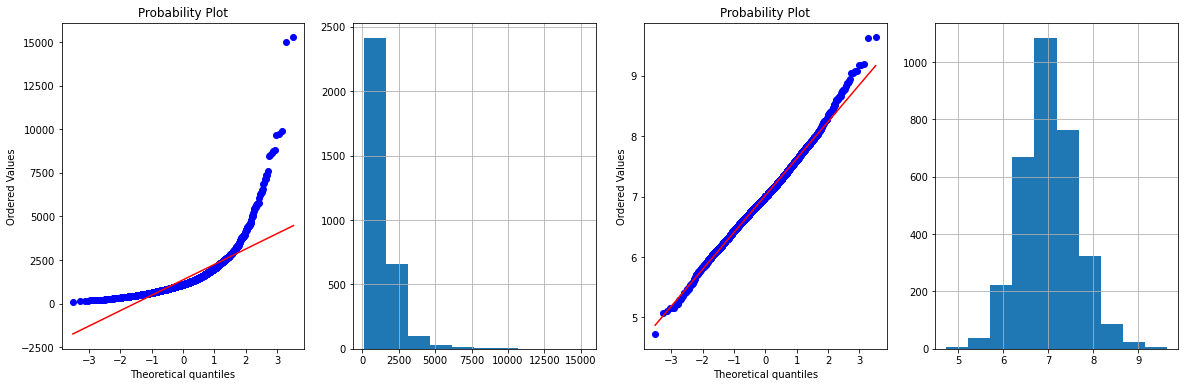

In [31]:
# Income Transformation using Logarithmic 
for i in income_list:
        transform_feature_log(df, i)

plot_data_transformation(df, 'IncomePerCapErr', 'IncomePerCapErr_log')

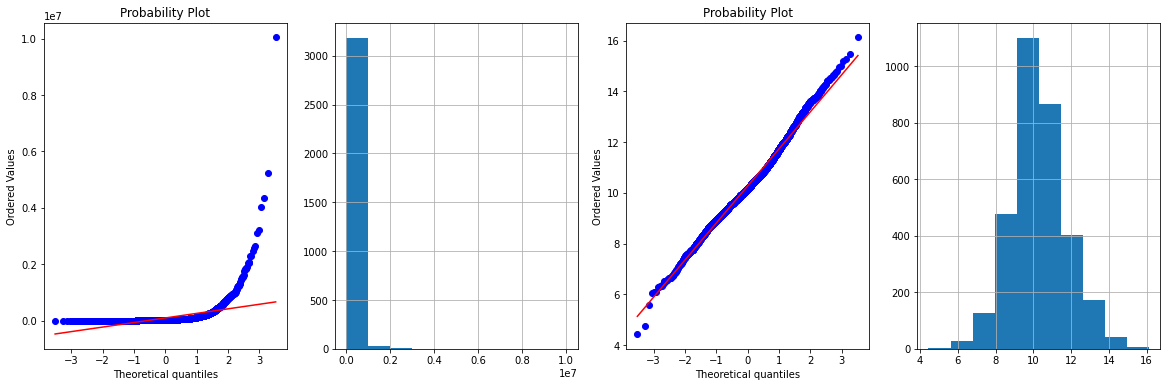

In [32]:
transform_feature_log(df, 'TotalPop')
plot_data_transformation(df, 'TotalPop', 'TotalPop_log')

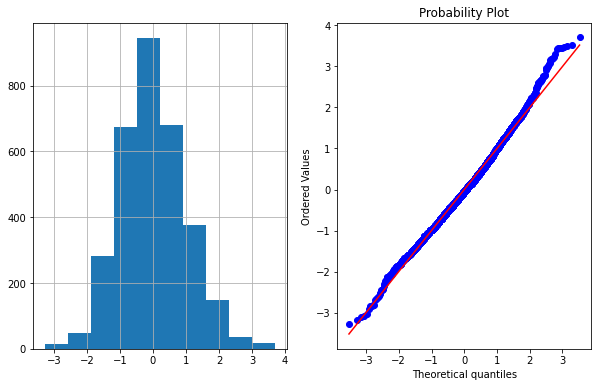

In [33]:
scaler = StandardScaler()
df[["MeanCommute_scale"]] = scaler.fit_transform(df[["MeanCommute"]])

plot_distribution(df, 'MeanCommute_scale')

In [34]:
df = df.drop(old_columns, axis = 1)

# Feature Selection
- Dropping low variance variables 
- Pearson Correlation 
- Principal Component Analysis

In [35]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

df = clean_dataset(df)

<AxesSubplot:>

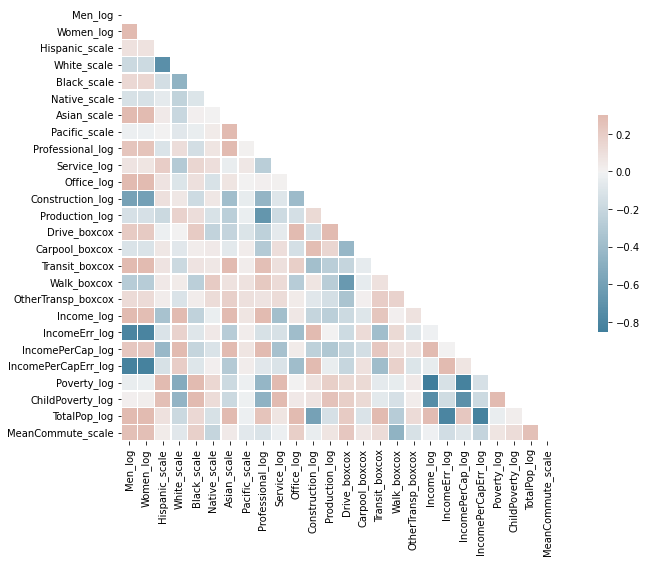

In [36]:
# compute corr array and generate a mask for the upper triangle
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.subplots(figsize=(15,8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# plt heatmap with mask and ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [37]:
var_threshold = VarianceThreshold(threshold=0.05)
var_threshold.fit(df)

# get the number of feature coumns with 0 variance 
constant_col = [col for col in df.columns if col not in df.columns[var_threshold.get_support()]]
# drop feature with 0 variance (constanct features) 
df.drop(constant_col, axis=1, inplace=True)

print(constant_col)

['Professional_log', 'Service_log', 'Office_log', 'Transit_boxcox']


In [38]:
def drop_corr(df, threshold):
	# set of all the names of correlated columns
    col_corr = set()
    corr_matrix = df.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
			# get the coefficient value
            if corr_matrix.iloc[i, j] > threshold:
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr
    
corr_features = drop_corr(df, 0.80)
print(corr_features)
df.drop(corr_features, axis=1, inplace=True)


{'ChildPoverty_log', 'IncomePerCap_log', 'Women_log', 'IncomePerCapErr_log', 'TotalPop_log'}


<AxesSubplot:>

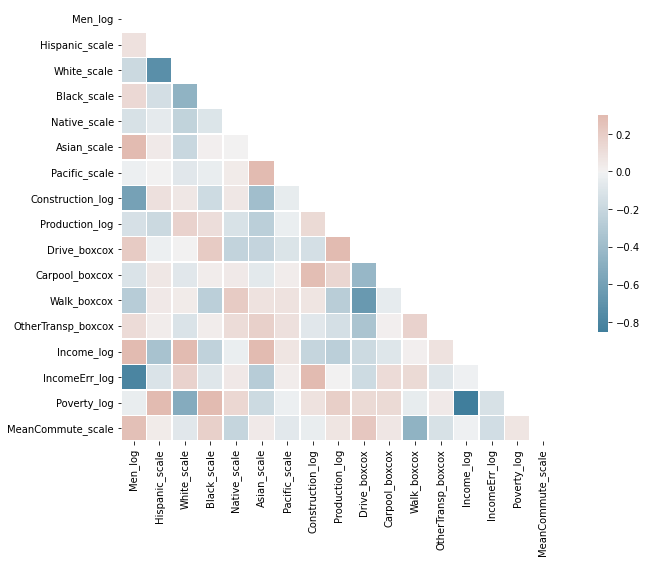

In [39]:
# compute corr array and generate a mask for the upper triangle
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.subplots(figsize=(15,8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# plt heatmap with mask and ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [40]:
df.to_csv('../inputs/population_seg_clean.csv', index=False)

In [41]:
# implement this in another rep py file 
# PCA for dimensionality reduction
# Clustering transformed data with k-means
# Use Kmeans clustering model and evalute model 
